# Ornstein Uhlenbeck Model

<h3>
A log likelihood process for optimal entry / exit / stopping on a mean reverting pair trading system
</h3>

### This notbook is in three states:
- Data 0: [Import the historical prices and normalise](0:-Import-the-historical-prices-and-normalise)
- State 1: [Estimate ornstein-uhlenbeck (OU)](State-1:-Estimate-ornstein-uhlenbeck-(OU))
- State 2: [Optimal Stopping problem](State-2:-Optimal-Stopping-problem)
- State 3: [Plot results](State-3:-Plot-results)

<hr>

## 0:  Import the historical prices and normalise
From our database that collects the 1m candlestick historical data from Bitmex, we can import the chosen two coins for the test.

The coins can be selected from a process by applying PCA and OPTICS clustering to pair prices. The file: [Unsupervised pairs selection]() cam be found here.

But in this case we will be testing on GLD (Gold prices) and GDX (a gold ETF), the reason being they should be fairly stable and similar in price movements.

I also import SLV (Silver prices) for testing.

The data is stored on a HDF5 file system where we can retrieve any given timeframe from the dates specified. 

In this project we will be using 1min candles over the course of a single day


In [1]:
import pandas as pd
import datetime
# import math
from math import sqrt, log, pi, exp  # exp(n) == e^n, log(n) == ln(n)
import matplotlib.pyplot as plt
import scipy.optimize as so
import numpy as np

# from database import Hdf5Client
from utils import resample_timeframe


%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]

c1, c2 = 'GLD', 'GDX'
coin_1 = pd.read_csv('./stock_data/GLD_historical.csv')['Close']
coin_2 = pd.read_csv('./stock_data/GDX_historical.csv')['Close']
coin_3 = pd.read_csv('./stock_data/SLV_historical.csv')['Close']
M = 5
coin_1 = coin_1[M:M + 200]
coin_2 = coin_2[M:M + 200]
coin_3 = coin_3[M:M + 200]
dt = 1 / 252



Fist we show our portfolio if we were holding just $1 of each stock/coin over the time period

<AxesSubplot:>

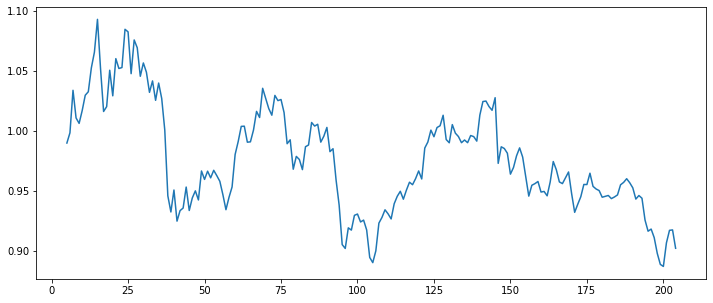

In [2]:
ts_xrp1 = coin_1 / coin_1.iloc[0]
ts_eos1 = coin_2 / coin_2.iloc[0]

portfolio = ts_xrp1 - .01 * ts_eos1
portfolio.plot()

# State 2: Estimate ornstein-uhlenbeck (OU)


Compute the log likelihood


$$- \frac{1}{2} \ln(2\pi) - \ln(\tilde{\sigma})-\frac{1}{2n\tilde{\sigma}^2}\displaystyle \sum_{i=1}^{n}[x_i^{\alpha,\beta}-x_{i-1}^{\alpha,\beta}e^{-\mu\Delta t}-\theta(1-e^{-\mu\Delta t})]^2$$

In [3]:
def log_likelihood(parameters, S, dt):
    theta = parameters[0]
    mu = parameters[1]
    sigma = parameters[2]

    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt(sigma0)

    N = S.size

    term1 = -0.5 * np.log(2 * np.pi)
    term2 = -np.log(sigma0)
    prefactor = -1 / (2 * N * sigma0**2)

    sum_term = 0
    for i in range(1, N):
        x2 = S[i]
        x1 = S[i-1]

        sum_term = sum_term + (x2 - x1 * np.exp(-mu*dt) -
                               theta * (1-np.exp(-mu*dt)))**2

    f = (term1 + term2 + prefactor * sum_term)

    return f

Estimate coefficients for OU
* Theta - Desciption
* Mu - Description
* Sigma - Description


To express the parameter values that maximise the average log-likeihood, we define tthe following:

$$ X_x = \displaystyle \sum_{i=1}^{n} x_{i-1}^{\alpha,\beta},$$
$$ X_y = \displaystyle \sum_{i=1}^{n} x_{i}^{\alpha,\beta},$$
$$ X_{xx} = \displaystyle \sum_{i=1}^{n} (x_{i-1}^{\alpha,\beta})^2,$$
$$ X_{xy} = \displaystyle \sum_{i=1}^{n} x_{i-1}^{\alpha,\beta} x_i^{\alpha,\beta},$$
$$ X_{yy} = \displaystyle \sum_{i=1}^{n} (x_{i}^{\alpha,\beta})^2,$$


We get the optimal parameters ($\theta, \mu, \sigma$) under the OU model, explicitly by:

$$ \theta^* = \frac{X_yX_{xx} - X_xX_{xy}}{n(X_{xx} - X_{xy}) - (X_x^2 - X_xX_y)}, $$
$$ \mu^*  = -\frac{1}{\Delta t} \ln\frac{X_{xy}-\theta^*X_x-\theta^*X_y+n(\theta^*)^2}{X_{xx}-2\theta^*X_x+n(\theta^*)^2},$$
$$ (\sigma^*)^2 = \frac{2\mu^2}{n(1-e^{-2\mu^*\Delta t})} (X_{yy}-2e^{-\mu^*\Delta t} X_{xy} +e^{-2\mu^*\Delta t}X_{xx} - 2\theta^*(1-e^{-\mu^*\Delta t}) (X_y-e^{-\mu^*\Delta t} X_x) + n(\theta^*)^2(1-e^{-\mu*\Delta t})^2)$$

In [4]:
def calculate_parameters(x, dt):
    # Page 13

    N = x.size

    Xx = np.sum(x[0:-1])
    Xy = np.sum(x[1:])
    Xxx = np.sum(x[0:-1]**2)
    Xxy = np.sum(x[0:-1] * x[1:])
    Xyy = np.sum(x[1:]**2)

    theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy))

    mu0 = (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
    mu0 = -1 / dt * np.log(mu0)

    prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
    term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(
        1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * (1-np.exp(-mu0 * dt))**2

    sigma02 = prefactor * term
    sigma0 = np.sqrt(sigma02)

    return theta0, mu0, sigma0

Collect params Log likelihood and optimal theta, mu, sigma


In [5]:
B_over_A = np.linspace(0.001, 1, 1000)
# Make this more efficient by holding value only if bigger than prev value
likelihood = []
params = []
a1 = coin_1.to_numpy()
b1 = coin_2.to_numpy()

for value in B_over_A:
    alpha = 1 / a1[0]

    beta = value / b1[0]

    X = alpha * a1 - beta * b1

    parameters = calculate_parameters(X, dt)

    likelihood.append(log_likelihood(parameters, X, dt))
    params.append(parameters)


**Plot the log_likelihood**

We want to plot things in terms of B, but we set A = 1 above so B/A = B.
I am just making it explicit here for clarity.

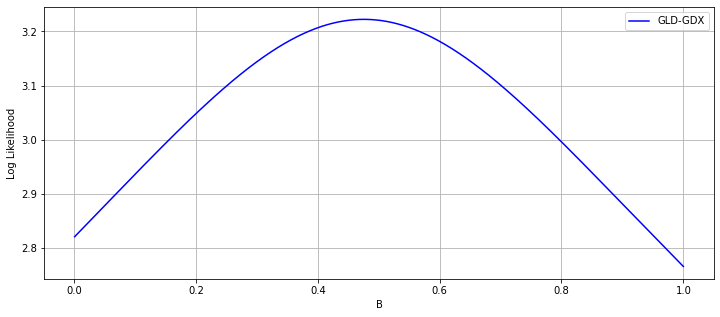

In [6]:
B = B_over_A * 1
plt.plot(B, likelihood, 'b', label=f'{c1}-{c2}')
plt.xlabel('B')
plt.ylabel('Log Likelihood')
plt.grid()
plt.legend()
plt.show()

### Collect B: The $ allocation ratio to asset B

$$ \beta^* = \arg \max \hat{\mathscr{L}} (\theta^*, \mu^*, \sigma^*|x_0^{\alpha,\beta}, x_1^{\alpha,\beta},...,x_n^{\alpha,\beta}).$$

In [7]:
V = np.amax(likelihood)
ind = np.where(likelihood == V)
ind = ind[0]
beta_amount = B[ind][0]
calculated_params = params[int(ind)]

theta, mu, sigma = calculated_params[0], calculated_params[1], calculated_params[2]

print('\nGLD-GDX: ', B[ind][0])
print('theta:', theta)
print('Mu:', mu)
print('Sigma:', sigma)
print('Beta:', beta_amount)


GLD-GDX:  0.47600000000000003
theta: 0.5202948615852797
Mu: 5.3405317280317535
Sigma: 0.15521436221362547
Beta: 0.47600000000000003


### Chart the ratio of holding coin A and shorting beta of coin B

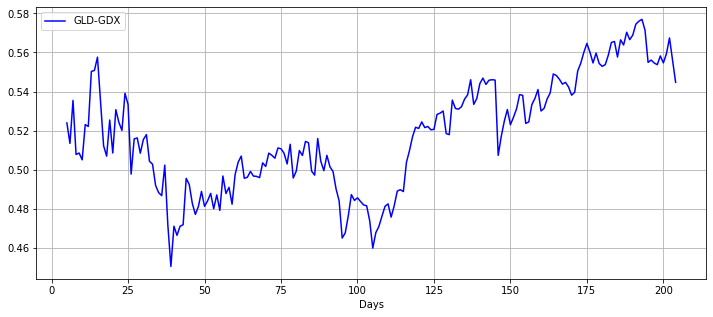

In [8]:
c1_chart = coin_1 / coin_1.iloc[0]
c2_chart = coin_2 / coin_2.iloc[0]

ts1 = c1_chart - (beta_amount * c2_chart)

plt.plot(ts1, 'b', label=f'{c1}-{c2}')
plt.xlabel('Days')
plt.grid()
plt.legend()
plt.show()

## State 3: Optimal Stopping problem

Solve the optimal stopping problem which gives us the best prices to buy and sell
   * b = optimal value we want to sell
   * d = optimal value we want to buy
   * So b > d

In [9]:
import mpmath as mp  # higher floating point precision, prevents arithmetic overflows
import scipy.optimize as so
import scipy.integrate as si
from scipy.optimize import root_scalar
import numpy as np

class OptimalStopping:
    '''
    Optimal Stopping Provides Functions for computing the Optimal Entry and Exit for our Pairs Portfolio

    Functions V and J are the functions used to calculate the Exit and Entry values, respectively
    '''
    def __init__(self, theta, mu, sigma, l, r=.05, c=.05):
        '''
        x - current portfolio value
        theta, mu, sigma - Ornstein-Uhlenbeck Coefficients
            (note we use self.theta for mean and self.mu for drift,
            while some sources use self.mu for mean and self.theta for drift)
        r - investor's subject discount rate
        c - cost of trading (fees)
        '''

        self.theta = theta
        self.mu = mu
        self.sigma = sigma

        self.liquidation_level = [None, None]
        self.entry_level = [None, None]

        self.r = r
        self.c = c
        self.L = l

        self.b_star = self.b()
        self.F_of_b = self.F(self.b_star)

        self.d_star = self.d()

    def UpdateFields(self, theta=None, mu=None, sigma=None, r=None, c=None):
        '''
        Update our OU Coefficients
        '''    
        if theta is not None:
            self.theta = theta
        if mu is not None:
            self.mu = mu
        if sigma is not None:
            self.sigma = sigma
        if r is not None:
            self.r = r
        if c is not None:
            self.c = c

        self.b_star = self.b()
        self.F_of_b = self.F(self.b_star)
        
        self.d_star = self.d()

    def Entry(self):
        '''
        Optimal value to enter/buy the portfolio
        '''
        self.optimal_entry_interval_stop_loss()
        return self.entry_level
    
    def Exit(self):
        '''
        Optimal value to exit/liquidate the portfolio
        '''
        self.optimal_liquidation_level_stop_loss()
        return self.liquidation_level
    
    def V(self, x):
        # equation 2.29

        if x < self.b_star:
            return (self.b_star - self.c) * self.F(x) / self.F_of_b
        else:
            return x - self.c

    def F(self, x):
        # equation 2.11
        def integrand(u):
            return u ** (self.r / self.mu - 1) * mp.exp(mp.sqrt(2 * self.mu / self.sigma ** 2) * (x - self.theta) * u - u ** 2 / 2)

        return si.quad(integrand, 0, np.inf)[0]

    def G(self, x):
        # equation 2.12
        def integrand(u):
            return u ** (self.r / self.mu - 1) * mp.exp(mp.sqrt(2 * self.mu / self.sigma ** 2) * (self.theta - x) * u - u ** 2 / 2)

        return si.quad(integrand, 0, np.inf)[0]

    def b(self):
        # estimates b* using equation 2.30

        def func(b):
            return self.F(b) - (b - self.c) * self.Prime(self.F, b) # self.F(b) not needed?

        # finds the root of function between the interval [0, 1]
        output = so.brentq(func, 0, 1)
        self.liquidation_level[0] = output

        return output

    def d(self):
        # estimates d* using equation 2.37

        def func(d):
            return (self.G(d) * (self.Prime(self.V, d) - 1)) - (self.Prime(self.G, d) * (self.V(d) - d - self.c))

        # finds the root of function between the interval [0, 1]
        output = so.brentq(func, 0, 1)
        self.entry_level[0] = output

        return output

    def Prime(self, f, x, h=1e-4):
        # given f, estimates f'(x) using the difference quotient formula 
        # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
        return (f(x + h) - f(x)) / h

    def _C(self):
        """
        Calculates helper function to further define the exit/enter
        level with a stop-loss level. (p.31)
        :return: (float) Value of C function.
        """

        # Setting liquidation level with respect to stop-loss
        liquidation_sl = self.optimal_liquidation_level_stop_loss()

        # Calculating C function value
        calculated_c = (((liquidation_sl - self.c)
                         * self.G(self.L)
                         - (self.L - self.c)
                         * self.G(liquidation_sl))
                        / (self.F(liquidation_sl)
                           * self.G(self.L)
                           - self.F(self.L)
                           * self.G(liquidation_sl)))

        return calculated_c

    def _D(self):
        """
        Calculates helper function to further define the exit/enter level
        with a stop-loss level. (p.31)
        :return: (float) Value of D function.
        """

        # Setting liquidation level with respect to stop-loss
        liquidation_sl = self.optimal_liquidation_level_stop_loss()

        # Calculating D function value
        calculated_d = (((self.L - self.c)
                         * self.F(liquidation_sl)
                         - (liquidation_sl - self.c)
                         * self.F(self.L))
                        / (self.F(liquidation_sl)
                           * self.G(self.L)
                           - self.F(self.L)
                           * self.G(liquidation_sl)))

        return calculated_d

    def V_sl(self, price):
        """
        Calculates the expected discounted value of liquidation of the position
        considering the stop-loss level. (p. 31)
        :param price: (float) Portfolio value.
        :return: (float) Expected discounted value of liquidating the position
            considering the stop-loss level.
        """

        # Checking if the sl level was allocated
        if self.L is None:
            raise Exception(
                "To use this function stop-loss level must be allocated.")

        liquidation_sl = self.optimal_liquidation_level_stop_loss()

        # V_sl function value
        if (self.L < price < liquidation_sl):
            output = self._C() * self.F(price) \
                + self._D() * self.G(price)
        else:
            output = price - self.c

        return output

    def _V_sl_derivative(self, price, h=1e-4):
        """
        Calculates the derivative of the expected discounted value of liquidation
        of the position considering the stop-loss level.
        :param price: (float) Portfolio value.
        :param h: (float) Delta step to use to calculate derivative.
        :return: (float) Expected discounted value of liquidating the position
            considering the stop-loss level.
        """

        # Numerically calculating the derivative
        output = (self.V_sl(price + h) - self.V_sl(price)) / h

        return output

    def optimal_liquidation_level_stop_loss(self):
        """
        Calculates the optimal liquidation portfolio level considering the stop-loss level. (p.31)
        :return: (float) Optimal liquidation portfolio level considering the stop-loss.
        """

        # Checking if the sl level was allocated
        if self.L is None:
            raise Exception(
                "To use this function stop-loss level must be allocated.")

        # If the liquidation level wasn't calculated before, set it
        if self.liquidation_level[1] is None:

            # Calculating three sub-parts of the equation
            def a_var(price): return ((self.L - self.c)
                                      * self.G(price)
                                      - (price - self.c)
                                      * self.G(self.L)) \
                * self.Prime(self.F, price)

            def b_var(price): return ((price - self.c)
                                      * self.F(self.L)
                                      - (self.L - self.c)
                                      * self.F(price)) \
                * self.Prime(self.G, price)

            def c_var(price): return (self.G(price)
                                      * self.F(self.L)
                                      - self.G(self.L)
                                      * self.F(price))

            # Final equation
            def equation(price): return a_var(price) + \
                b_var(price) - c_var(price)

            bracket = [self.theta - 6 * self.sigma,
                       self.theta + 6 * self.sigma]

            sol = root_scalar(equation, bracket=bracket)

            # The root is the optimal liquidation level considering the stop-loss level
            output = sol.root

            self.liquidation_level[1] = output

        else:

            output = self.liquidation_level[1]

        return output

    def optimal_entry_interval_stop_loss(self):
        """
        Calculates the optimal entry portfolio interval considering the stop-loss level. (p.35)
        :return: (tuple) Optimal entry portfolio interval considering the stop-loss.
        """

        # Checking if the sl level was allocated
        # if self.L is None:
        #     raise Exception(
        #         "To use this function stop-loss level must be allocated.")
     
        # # If the entry level wasn't calculated before, set it
        # if self.entry_level[1] is None:

        #     def equation1(price): return (self.F(price) *
        #                                   (self._V_sl_derivative(price) - 1)
        #                                   - self.Prime(self.F, price)
        #                                   * (self.V_sl(price) - price - self.c[1]))

        #     def equation2(price): return (self.G(price)
        #                                   * (self._V_sl_derivative(price) - 1)
        #                                   - self.Prime(self.G, price)
        #                                   * (self.V_sl(price) - price - self.c[1]))

        #     # Set the liquidation level to previously calculated value
        #     b = self.liquidation_level[1]

        #     bracket = [self.L, b]

        #     # Solving the equations
        #     sol2 = root_scalar(equation2, bracket=bracket)

        #     sol1 = root_scalar(equation1, bracket=[self.L, sol2.root])

        #     output = [round(sol1.root, 5), round(sol2.root, 5)]

        #     self.entry_level[1] = output

        # else:

        #     output = self.entry_level[1]

        # return output

### Set stop-loss levels

In [10]:
L = ts1.mean()
std_dev = ts1.std()
L = L-2*std_dev
print("Stop Loss:", L)

Stop Loss: 0.46031935860329554


In [11]:
r = .05
c = .02

opt_stopping = OptimalStopping(theta, mu, sigma, L, r, c)
entry = opt_stopping.Entry()
exit = opt_stopping.Exit()

print('Entry:', entry, '\nExit:', exit)


/var/folders/b1/8ygvz1891pb28243s84n4sxm0000gn/T/ipykernel_55076/1459064645.py:86: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]
/var/folders/b1/8ygvz1891pb28243s84n4sxm0000gn/T/ipykernel_55076/1459064645.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(integrand, 0, np.inf)[0]


Entry: [0.4035001069091624, None] 
Exit: [0.5983867621177081, 0.5439305543733768]


## State 4: Plot results

* L        : stop-loss level
* ...      : optimal entry d*L
* ---      : optimal exit b*L

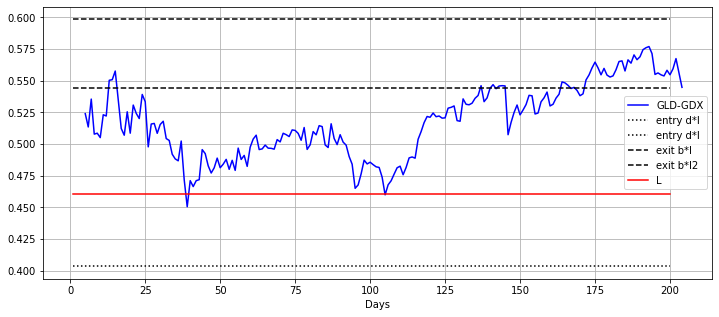

In [12]:
x = [i for i in range(1, 201)]

data_length = len(ts1)

plt.plot(ts1, 'b', label=f'{c1}-{c2}')
plt.plot(x, [entry]*data_length,':k', label='entry d*l')
plt.plot(x, [exit[0]]*data_length,'--k', label='exit b*l')
plt.plot(x, [exit[1]]*data_length,'--k', label='exit b*l2')
plt.plot(x, [L]*data_length, 'r', label="L")
plt.xlabel('Days')
plt.grid()
plt.legend()
plt.show()